Based on the results that we have obtained from the qiime2 commands, it would be nice to dig in a little further to actually determine the microbes present in each of the balances. To do this, we'll need to get a little more familiar with the Qiime2 Artifact API. To access the underlying data within Qiime2 Artifacts, we'll need to load them into memory, and convert the contents into more familiar Python objects.

In [1]:
import qiime2
import pandas as pd
from skbio import TreeNode
from gneiss.regression import OLSModel
import matplotlib.pyplot as plt
%matplotlib inline

# Load the table
table_art = qiime2.Artifact.load('88soils_filt100.biom.qza')
table = table_art.view(pd.DataFrame)

# Load the metadata
metadata = pd.read_table('88soils_modified_metadata.txt', index_col=0)

# Obtain the tree
tree_art = qiime2.Artifact.load('ph_tree.nwk.qza')
tree = tree_art.view(TreeNode)

# Unpack the results from the regression
viz = qiime2.Visualization.load('88soils_regression_summary.qzv')
viz.export_data('regression_summary_dir')
predicted_balances = pd.read_csv('regression_summary_dir/predicted.csv', index_col=0)

Now we'll want to see how good of a prediction the regression can perform. We'll visualize the raw heatmap next to the predicted heatmap. The rows and columns will be sorted using the pH information. We'll be using the function `niche_sort` to handle this.

In [2]:
from gneiss.sort import niche_sort
observed_table = niche_sort(table, metadata.ph)

Note that the regression we made was performed directly on the balances.  However, we want to see how good the prediction was done of the proportions.  Fortunately, we can map the results from the balances directly back to the proportions using the inverse ilr transform.

In [3]:
from skbio.stats.composition import ilr_inv
from gneiss.balances import balance_basis

basis, nodes = balance_basis(tree)
ids = [n.name for n in tree.tips()]

predicted_table = ilr_inv(predicted_balances.T, basis)
predicted_table = pd.DataFrame(predicted_table, columns=ids, 
                               index=predicted_balances.columns)
predicted_table = predicted_table.reindex(index=observed_table.index,
                                          columns=observed_table.columns)

Now we have obtained the predicted proportions, let's see how these compare with the raw proportions.

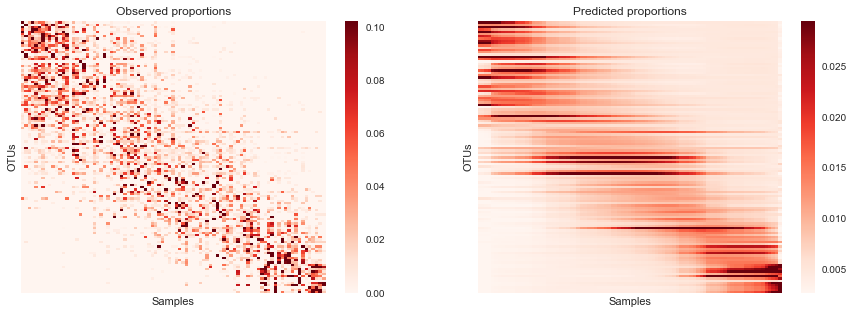

In [4]:
from skbio.stats.composition import closure
import seaborn as sns
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
sns.heatmap(closure(observed_table.T), robust=True, ax=ax1, cmap='Reds')
sns.heatmap(predicted_table.T, robust=True, ax=ax2, cmap='Reds')
ax1.set_title('Observed proportions')
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax1.set_xlabel('Samples')
ax1.set_ylabel('OTUs')
ax2.set_title('Predicted proportions')
ax2.set_xlabel('Samples')
ax2.set_ylabel('OTUs')

From this, it is clear that the linear regression on balances can capture the overall trends of OTUs vs pH. Ecologically, this makes sense. Bacteria tend to prefer to live in specific ranges of pH. So it isn't entirely surprising that microbial abundances can be predicted from pH. At the same time, the pattern was not obviously apparent until linear regressions on balances were applied.
In short, applying linear regressions to balances are useful for studying gradients.